In [57]:
import deepxde as dde
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from deepxde.callbacks import ModelCheckpoint
from deepxde.callbacks import Callback

In [58]:
# Set random seed
seed = 0
np.random.seed(seed)
tf.random.set_seed(seed)
dde.backend.tf.random.set_random_seed(seed)

# Set hyperparameters
n_output = 3 # postition (x), theta, force on cart (u_norm)

num_domain = 1000

n_adam = 5000

lr = 3e-3 # for Adam
loss_weights = [1., 1., 1., 1., 1., 1, 1., 1.]

# Set physical parameters
tmin, tmax = 0.0, 10.0
# xmin, xmax = -5.0, 5.0
target = np.pi # cos(theta) should be close to 180 degrees

# Define constants
M = 2 # Mass of the cart
m = 1 # Mass of the pendulum
b = 0.1 # Friction coefficient
I = 0.33 # Moment of inertia
g = 9.8 # Gravity
l = 1 # Length of the pendulum
force_max = 0.5  # Maximum force

In [59]:
class Custom_BC(dde.icbc.BC):
    def __init__(self, geom, func, on_boundary, component=0):
        super().__init__(geom, on_boundary, component)
        self.func = dde.icbc.boundary_conditions.npfunc_range_autocache(dde.utils.return_tensor(func))
        
    def error(self, X, inputs, outputs, beg, end, aux_var=None):
        # beg and end specify the current batch range
        values = self.func(X, beg, end, aux_var)
        theta = outputs[:, 1:2]
        goal = theta
        return (goal[beg:end, self.component:self.component + 1] - values) ** 2

In [60]:
def ode(t, u):
    x, theta, force_norm = u[:, 0:1], u[:, 1:2], tf.tanh(u[:, 2:3])
    force = force_max * force_norm
    x_dot = dde.grad.jacobian(x, t)
    theta_dot = dde.grad.jacobian(theta, t)
    x_ddot = dde.grad.jacobian(x_dot, t)
    theta_ddot = dde.grad.jacobian(theta_dot, t)

    denominator = I * (M + m) + M * m * l * l

    res1 = x_ddot - (((-(I + m * l * l) * b * x_dot) + (m * m * g * l * l * theta) + ((I + m * l * l) * force)) / denominator)
    res2 = theta_ddot - (((-m * b * l * theta_dot) + (m * g * (M + m) * l * theta) +( m * l * force)) / denominator)

    return [res1, res2]

In [61]:
def initial(_, on_initial):
    return on_initial

def boundary_left(t, on_boundary):
    '''
        on_boundary is passed here by deepxde and it serves as an intial filter which tells if a point lies on the boundary or not

        np.isclose(t[0], tmin) checks if the point is on the left boundary or not and this is a second filter
    '''

    return on_boundary * np.isclose(t[0], tmin)

def boundary_right(t, on_boundary):
    '''
        on_boundary is passed here by deepxde and it serves as an intial filter which tells if a point lies on the boundary or not

        np.isclose(t[0], tmax) checks if the point is on the right boundary or not and this is a second filter
    '''

    return on_boundary * np.isclose(t[0], tmax)

In [62]:
geom = dde.geometry.TimeDomain(tmin, tmax)

# INITIAL CONDITIONS
position_initial = dde.icbc.IC(geom, lambda t: np.array([0.]), initial, component=0) # posittion = 0 at time = 0
theta_initial = dde.icbc.IC(geom, lambda t: np.array([0.]), initial, component=1) # theta = 0 at time = 0
force_initial = dde.icbc.IC(geom, lambda t: np.array([0.]), initial, component=2) # force = 10 at time = 0

# NEUMANN CONDITIONS
velocity_initial = dde.icbc.NeumannBC(geom, lambda t: np.array([0.]), boundary_left, component=0) # cart velocity = 0 at time = 0
angular_velocity_initial = dde.icbc.NeumannBC(geom, lambda t: np.array([0.]), boundary_left, component=1) # angular velocity 1 = 0 at time = 0

# CUSTOM BOUNDARY CONDITIONS - GOAL AND POSITION RANGE
goal = Custom_BC(geom, lambda t: np.array([target]), boundary_right) # custom ICBC

losses = [position_initial, theta_initial, force_initial, velocity_initial, angular_velocity_initial, goal]

data = dde.data.PDE(geom, ode, losses, num_domain=num_domain, num_boundary=50)
# dataset size here will be 1002 (1000 domain + 2 boundary)

In [63]:
net = dde.nn.FNN([1] + [64] * 7 + [n_output], "sigmoid", "Glorot normal")

In [64]:
resampler = dde.callbacks.PDEPointResampler(period=500)

In [65]:
model = dde.Model(data, net)
model.compile("adam", lr=lr, loss_weights=loss_weights)

Compiling model...
Building feed-forward neural network...
'build' took 0.168000 s

'compile' took 2.291621 s



In [66]:
# class PrintOutputsCallback(Callback):
#     def __init__(self, data):
#         super(PrintOutputsCallback, self).__init__()
#         self.data = data  # Data used for prediction (e.g., time or spatial points)

#     def on_epoch_end(self):
#         predictions = model.predict(self.data)
#         print("Model predictions at the end of epoch:", predictions[-1])

# time = np.linspace(tmin, tmax, num_domain)
# time = time.reshape(-1, 1)

# # Create an instance of the callback
# print_outputs_callback = PrintOutputsCallback(time)

In [67]:
model_checkpoint = ModelCheckpoint(
    filepath='checkpoints/best_model.ckpt',  # Path to save the model file
    monitor='test loss',          # Monitor the validation loss
    save_better_only=True          # Only save when the monitored quantity (val_loss) has improved
)

In [68]:
print("Residual 1 | Residual 2 | Initial Position | Initial Theta | Initial Force | Initial Velocity | Initial Angular Velocity | Goal")
losshistory, train_state = model.train(display_every=10, iterations=n_adam, callbacks=[resampler, model_checkpoint])
# losshistory, train_state = model.train(display_every=100, iterations=n_adam, callbacks=[print_outputs_callback])

Residual 1 | Residual 2 | Initial Position | Initial Theta | Initial Force | Initial Velocity | Initial Angular Velocity | Goal
Training model...

Step      Train loss                                                                          Test loss                                                                           Test metric
0         [2.40e+01, 2.29e+02, 1.65e+00, 2.41e+00, 2.10e-01, 8.06e-12, 5.06e-12, 4.85e+02]    [2.40e+01, 2.29e+02, 1.65e+00, 2.41e+00, 2.10e-01, 8.06e-12, 5.06e-12, 4.85e+02]    []  
INFO:tensorflow:checkpoints/best_model.ckpt-1.ckpt is not in all_model_checkpoint_paths. Manually adding it.
10        [1.44e+01, 1.20e+02, 5.62e-02, 1.20e+00, 2.29e-01, 1.38e-13, 1.70e-11, 1.75e+01]    [1.44e+01, 1.20e+02, 5.62e-02, 1.20e+00, 2.29e-01, 1.38e-13, 1.70e-11, 1.75e+01]    []  
INFO:tensorflow:checkpoints/best_model.ckpt-10.ckpt is not in all_model_checkpoint_paths. Manually adding it.
20        [1.68e+00, 1.73e+01, 1.86e-02, 1.86e-01, 7.52e-02, 1.14e-12, 8.01e-1

## Getting the predictions for time = 0 to time = 10 at intervals of 0.01

INFO:tensorflow:Restoring parameters from checkpoints/best_model.ckpt-4880.ckpt


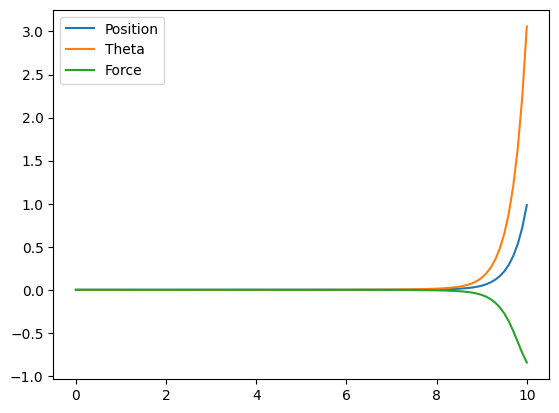

In [69]:
model.restore(save_path='checkpoints/best_model.ckpt-4880.ckpt')

t = np.linspace(tmin, tmax, 101)
predictions = model.predict(np.array([t]).T)
predictions[:, 2] = np.tanh(predictions[:, 2]) * force_max

plt.plot(t, predictions[:, 0], label="Position")
plt.plot(t, predictions[:, 1], label="Theta")
plt.plot(t, predictions[:, 2], label="Force")
plt.legend()
plt.show()

In [70]:
np.save('single_inverted_cart_outputs.npy', predictions)
predictions

array([[ 8.35172832e-05, -1.98183209e-03,  1.58468261e-04],
       [ 8.43228772e-05, -1.97925791e-03,  1.57432631e-04],
       [ 8.52728263e-05, -1.97695941e-03,  1.56415626e-04],
       [ 8.59685242e-05, -1.97427347e-03,  1.55290589e-04],
       [ 8.70153308e-05, -1.97160617e-03,  1.54146925e-04],
       [ 8.79988074e-05, -1.96876004e-03,  1.53047964e-04],
       [ 8.88956711e-05, -1.96561217e-03,  1.51606277e-04],
       [ 9.02200118e-05, -1.96230412e-03,  1.50160864e-04],
       [ 9.13031399e-05, -1.95886940e-03,  1.48748979e-04],
       [ 9.26293433e-05, -1.95516646e-03,  1.47176906e-04],
       [ 9.37664881e-05, -1.95124000e-03,  1.45258382e-04],
       [ 9.51169059e-05, -1.94700062e-03,  1.43913552e-04],
       [ 9.66098160e-05, -1.94286928e-03,  1.41868368e-04],
       [ 9.82750207e-05, -1.93813443e-03,  1.39927492e-04],
       [ 9.97968018e-05, -1.93341821e-03,  1.38023868e-04],
       [ 1.01497397e-04, -1.92823634e-03,  1.35445967e-04],
       [ 1.03428029e-04, -1.92278996e-03